In [2]:
library(tidyverse)
library(data.table)
library(magrittr)
library(ggridges)
library(ggthemes)
library(harmony)
library(singlecellmethods)
library(ggrepel)
library(Matrix)
library(patchwork)
library(sctransform)
library(scales)
library(uwot)
library(pheatmap)


fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}


# Make small test dataset

    TODO: make sparse dataset, make sure pct_in and pct_out still work
    TODO: remove . from all name, replace with _
    TODO: decide whether to report pct_in with dense matrices
    TODO: figure out how to deal with missing values (NA, NULL, Inf)

In [19]:
ngenes <- 25
ncells <- 50

samples1 <- matrix(rpois(55 * ngenes, 1), nrow = ngenes)
samples2 <- matrix(rpois(45 * ngenes, c(5, 7.5, 10, 12.5, 15) / 10), nrow = ngenes)
samples3 <- matrix(rpois(50 * ngenes, rev(c(5, 7.5, 10, 12.5, 15) / 10)), nrow = ngenes)


exprs <- Reduce(cbind, list(samples1, samples2, samples3))
meta_data <- data.frame(
#     type = rep(c('A', 'B', 'C'), each = ncells),
    type = rep(c('A', 'B', 'C'), c(55, 45, 50)),
    nUMI = colSums(exprs),
    nGene = colSums(exprs > 0)
)
head(meta_data)


colnames(exprs) <- paste0('X', seq_len(ncol(exprs)))
row.names(exprs) <- paste0('G', seq_len(nrow(exprs)))

type,nUMI,nGene
A,21,13
A,26,19
A,20,14
A,26,15
A,25,16
A,17,13


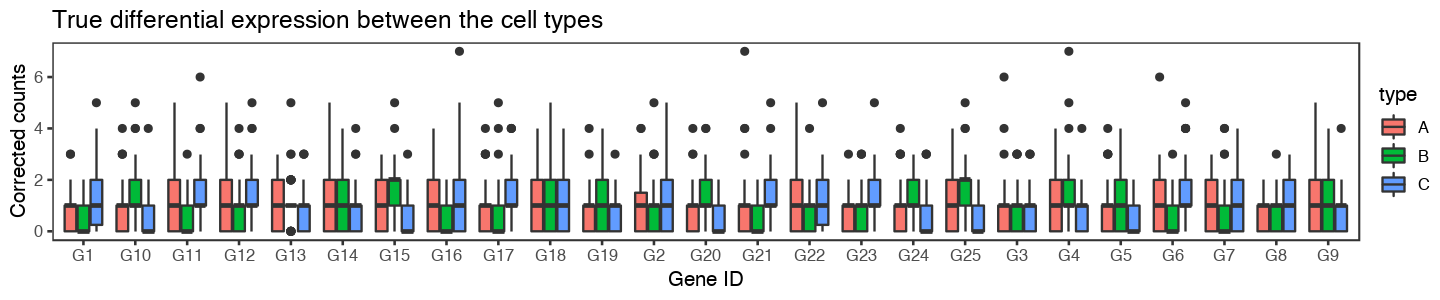

In [20]:
fig.size(2.5, 12)
exprs %>% 
    t %>% data.frame() %>% 
    cbind(meta_data) %>% 
    tidyr::gather(gene, val, -type, -nUMI, -nGene) %>%
    ggplot(aes(gene, val, fill = type)) + 
        geom_boxplot() + 
        theme_test(base_size = 12) + 
        labs(x = 'Gene ID', y = 'Corrected counts', 
             title = 'True differential expression between the cell types')

In [313]:
devtools::load_all()

Loading presto


## Baseline with R

In [467]:
data(y)
data(exprs)

N <- ncol(exprs)
D <- nrow(exprs)

res_base_r <- split(seq_len(N), y) %>% lapply(function(idx) {
    res <- Reduce(rbind, apply(exprs, 1, function(g) {
        wilcox.test(g[idx], g[setdiff(seq_len(N), idx)], exact = FALSE, 
                    correct = TRUE,
                    alternative = 'two.sided') %>% 
            broom::tidy()
    })) %>% data.frame()
    row.names(res) <- row.names(exprs)
    return(res)
})

res_base_r <- Reduce(rbind, lapply(names(res_base_r), function(group) {
    res_base_r[[group]] %>% data.frame() %>% 
        tibble::rownames_to_column('feature') %>% 
        dplyr::mutate(group = group)
})) %>% 
    dplyr::select(feature, group, statistic, p.value)


res_presto <- wilcoxauc(exprs, y) %>% 
    dplyr::select(feature, group, statistic, p.value = pval)

res_joint <- dplyr::inner_join(res_base_r, res_presto, by = c('feature', 'group'), suffix = c('_base', '_presto'))

# max(abs(res_joint$p.value_base - res_joint$p.value_presto)) < 1e-3
# max(abs(res_joint$statistic_base - res_joint$statistic_presto)) < 1e-3

In [356]:
library(testthat)
expect_lt(max(abs(res_joint$p.value_base - res_joint$p.value_presto)), 1e-3)
expect_lt(max(abs(res_joint$statistic_base - res_joint$statistic_presto)), 1e-3)

# Input data structures

In [23]:
devtools::load_all()

Loading wilcoxauc


In [24]:
X <- base::t(Xt)
X_dgc <- as(base::t(Xt), 'dgCMatrix')

x1 <- fast_diff_exp(X, y)
x2 <- fast_diff_exp(X_dgc, y)

ERROR: Error in .Call("_wilcoxauc_cpp_rank_matrix_dense", PACKAGE = "wilcoxauc", : "_wilcoxauc_cpp_rank_matrix_dense" not available for .Call() for package "wilcoxauc"


In [37]:
# x2$fdr %>% head

all(x1$auc == x2$auc)
all(x1$fdr == x2$fdr)
all(x1$lfc == x2$lfc)
all(x1$means == x2$means)
all(x1$means_nz == x2$means_nz)
all(x1$pct_in == x2$pct_in)
all(x1$pct_out == x2$pct_out)

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [38]:
x <- fast_wilcox(Xt, y)
x <- fast_wilcox(as(Xt, 'dgCMatrix'), y)
x <- fast_wilcox(as(Xt, 'dgTMatrix'), y)
x <- fast_wilcox(as(Xt, 'dgeMatrix'), y)
x <- fast_wilcox(as(Xt, 'TsparseMatrix'), y)


x <- fast_diff_exp(X, y)
x <- fast_diff_exp(as(X, 'dgCMatrix'), y)
x <- fast_diff_exp(as(X, 'dgTMatrix'), y)
x <- fast_diff_exp(as(X, 'dgeMatrix'), y)
x <- fast_diff_exp(as(X, 'TsparseMatrix'), y)


All other sparse and dense types are transformed into dgCMatrix and matrix

In [39]:
devtools::use_data()

Warning message:
“'devtools::use_data' is deprecated.
Use 'usethis::use_data()' instead.
See help("Deprecated") and help("devtools-deprecated").”

✔ Setting active project to '/Users/ikorsuns/Projects/wilcoxauc'


ERROR: Error: Nothing to save.


# Dealing with ties

http://www.statstutor.ac.uk/resources/uploaded/mannwhitney.pdf

In [40]:
N <- 1000
G <- 500
Xt <- t(matrix(rpois(N * G, .2), nrow = G))
Xt_dgc <- as(Xt, 'dgCMatrix')
y <- sample(10, N, TRUE)

## ratio of non-zero elements
length(Xt_dgc@x) / prod(dim(Xt_dgc))

[1] 0.180424

In [41]:
system.time({
    x <- fast_wilcox(Xt, y)
})
system.time({
    x2 <- fast_wilcox(Xt_dgc, y)
})

   user  system elapsed 
  0.032   0.003   0.034 

   user  system elapsed 
  0.010   0.000   0.009 

In [42]:
system.time({
    x <- fast_diff_exp(t(Xt), y)
})
system.time({
    x2 <- fast_diff_exp(Matrix::t(Xt_dgc), y)
})

   user  system elapsed 
  0.032   0.002   0.035 

   user  system elapsed 
  0.010   0.001   0.011 

# Output format

## How does Seurat do it? 

In [10]:
library(MUDAN)
data("pbmcA")
pbmcA <- pbmcA[, sample(ncol(pbmcA), 1000)]

In [11]:
library(dplyr)
library(Seurat)

# Load the PBMC dataset
# pbmc.data <- Read10X(data.dir = "../data/pbmc3k/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmcA, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

An object of class Seurat 
11129 features across 1000 samples within 1 assay 
Active assay: RNA (11129 features)

In [12]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(object = pbmc, pattern = "^MT-")

In [13]:
pbmc <- subset(x = pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [15]:
pbmc <- NormalizeData(object = pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

In [16]:
pbmc <- FindVariableFeatures(object = pbmc, selection.method = "vst", nfeatures = 2000)


In [17]:
pbmc <- ScaleData(object = pbmc)

Centering and scaling data matrix


In [18]:

pbmc <- RunPCA(object = pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  RPL13, RPS3A, RPS18, LTB, RPS2, IL32, CD7, IL7R, RPL7, CD2 
	   MAL, CCR7, CTSW, CCL5, CD8B, GZMA, CD8A, AQP3, CST7, RPL34 
	   PPP2R5C, GZMK, TRABD2A, SIT1, RGCC, PIM1, HOPX, MYC, FKBP11, MATK 
Negative:  CST3, FCN1, LYZ, TMEM176B, CD68, SPI1, LST1, S100A9, SERPINA1, CFD 
	   TYMP, CFP, S100A8, AIF1, MS4A6A, FCER1G, HCK, CD14, C19orf38, GRN 
	   MNDA, IGSF6, CTSS, PILRA, CPVL, FCGRT, TYROBP, PSAP, RP11-290F20.3, NCF2 
PC_ 2 
Positive:  RPL13, LTB, CD79A, RPS2, MS4A1, TCL1A, CD79B, VPREB3, RPLP1, HLA-DRA 
	   RPS18, HLA-DOB, HLA-DQA1, SPIB, LINC00926, FCER2, BANK1, CD19, HLA-DMB, BLK 
	   HLA-DQA2, NCF1, FCRLA, BLNK, RALGPS2, PPAPDC1B, GNG7, HLA-DMA, HLA-DQB1, FAM129C 
Negative:  NKG7, GNLY, CST7, GZMA, PRF1, GZMB, FGFBP2, CTSW, GZMH, CCL5 
	   FCGR3A, HOPX, CCL4, SPON2, GPR56, SRGN, CLIC3, TMSB4X, KLRD1, PFN1 
	   MATK, PRSS23, TYROBP, IFITM2, S100A4, IL2RB, ABI3, CD7, ID2, C12orf75 
PC_ 3 
Positive:  CD79A, TCL1A, CD79B, MS4A1, HLA-DQA1, HLA-DQA2, HLA-DPA1, HLA-DPB1

In [19]:
pbmc <- FindNeighbors(object = pbmc, dims = 1:10)
pbmc <- FindClusters(object = pbmc, resolution = 0.5)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 977
Number of edges: 35399

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8606
Number of communities: 7
Elapsed time: 0 seconds


In [87]:
cluster1.markers <- FindAllMarkers(object = pbmc, min.pct = 0.25, test.use = 'wilcox')
head(x = cluster1.markers, n = 5)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6


,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
RPL32,4.182650e-76,0.4112201,1.000,0.998,4.654871e-72,0,RPL32
S100A4,7.421732e-71,-1.6335786,0.502,0.874,8.259645e-67,0,S100A4
RPS13,1.149087e-70,0.5040517,1.000,0.992,1.278819e-66,0,RPS13
RPL11,1.083908e-69,0.3941974,1.000,0.998,1.206281e-65,0,RPL11
RPS3A,1.239261e-61,0.4699147,1.000,0.992,1.379173e-57,0,RPS3A


# Benchmarking


One big dataset, test effect of sparsity 

## stats::wilcox.test

In [52]:
wilcoxauc_base <- function(exprs, y) {
    N <- ncol(exprs)
    D <- nrow(exprs)

    res_base_r <- split(seq_len(N), y) %>% lapply(function(idx) {
        res <- Reduce(rbind, apply(exprs, 1, function(g) {
            wilcox.test(g[idx], g[setdiff(seq_len(N), idx)], exact = FALSE, 
                        correct = TRUE,
                        alternative = 'two.sided') %>% 
                broom::tidy()
        })) %>% data.frame()
        row.names(res) <- row.names(exprs)
        return(res)
    })


    res_base_r <- Reduce(rbind, lapply(names(res_base_r), function(group) {
        res_base_r[[group]] %>% data.frame() %>% 
            tibble::rownames_to_column('feature') %>% 
            dplyr::mutate(group = group)
    })) %>% 
        dplyr::select(feature, group, statistic, p.value)
    
}

## presto

In [401]:
library(Matrix)
library(data.table)
devtools::load_all()

N <- 1e3 ## num observations
D <- 1e2 ## num features
G <- 10 ## num of groups

X <- matrix(abs(rnorm(N * D)), D, N)
row.names(X) <- paste0('G', seq_len(D))

dim(X)
pryr::object_size(X)

Loading presto


[1]  100 1000

807 kB

In [403]:
time_res <- Reduce(rbind, lapply(seq(.1, 1, .1), function(d) {
    message(d)
    y <- sample(G, N, TRUE)        
    X_dense <- apply(X, 1, function(x) {
        x[sample(N, N * (1 - d), FALSE)] <- 0
        x
    }) %>% t() 
    X_sparse <- as(X_dense, 'dgCMatrix')

    time_dense <- system.time(x <- wilcoxauc(X_dense, y))
    time_sparse <- system.time(x <- wilcoxauc(X_sparse, y))
    time_base <- system.time(x <- wilcoxauc_base(X_sparse, y))
        
    data.table(density = d, dense = as.numeric(time_dense)[3], 
               sparse = as.numeric(time_sparse)[3], 
               base = as.numeric(time_base)[3]) 
}))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


In [ ]:
# save(x, a, obj1, file = 'jdks')
saveRDS(x, 'jklfsd')
my_new_name <- readRDS('jklfsd')

In [548]:
time_res_N

N,dense,sparse,base
1000,0.324,0.194,31.368
2000,0.312,0.198,27.986
3000,0.381,0.240,32.418
4000,0.484,0.287,40.853
5000,0.618,0.368,51.444
6000,1.265,0.332,58.397
7000,0.803,0.448,67.577
8000,1.387,0.407,73.157
9000,1.115,0.582,90.772
10000,1.567,0.587,93.922


## Case I: vary N

In [50]:
N <- 1e4 ## num observations
D <- 1e3 ## num features
G <- 10 ## num of groups

X <- matrix(abs(rnorm(N * D)), D, N)
# X <- abs(rsparsematrix(D, N, .1))
y <- sample(G, N, TRUE)

row.names(X) <- paste0('G', seq_len(D))


In [55]:
time_res_N <- Reduce(rbind, lapply(seq(1e3, 1e4, 1000), function(N) {
    message(N)
    idx <- sample(ncol(X), N, FALSE)
#     X_sparse <- X[, idx]
    X_dense <- as.matrix(X[, idx])
    y <- y[idx]
    

    time_dense <- system.time(x <- wilcoxauc(X_dense, y))
#     time_sparse <- system.time(x <- wilcoxauc(X_sparse, y))
    time_base <- system.time(x <- wilcoxauc_base(X_dense, y))
        
    data.table(N = N, 
               dense = as.numeric(time_dense)[1], 
#                sparse = as.numeric(time_sparse)[3], 
               base = as.numeric(time_base)[1]) 
}))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [62]:
time_res_N %>% fwrite('/data/srlab/ik936/presto_manuscript/time_res_N.csv')

In [61]:
240 / 1.2

[1] 200

In [59]:
238.167 / 60

[1] 3.96945

In [56]:
fig.size(2, 5)
time_res_N %>% 
    tidyr::gather(key, val, dense, sparse, base) %>% 
    subset(key %in% c('dense', 'base')) %>% 
    dplyr::mutate(key = case_when(
        key == 'dense' ~ 'Presto',
        key == 'base' ~ 'Base R',
        TRUE ~ key
    )) %>% 
    ggplot(aes(N, val, fill = key)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        scale_fill_tableau() + 
        labs(x = 'Number observations', y = 'Time elapsed (sec)') + 
        scale_x_continuous(breaks = seq(1e3, 1e4, 1000)) + 
        NULL

ERROR: Error in fig.size(2, 5): could not find function "fig.size"


In [431]:
fwrite(time_res_N, '~/Dropbox (Partners HealthCare)/presto/time_res_N.csv')

## Case II: vary sparsity 

In [486]:
library(Matrix)
library(data.table)
devtools::load_all()

N <- 1e5 ## num observations
D <- 1e3 ## num features
G <- 10 ## num of groups

X <- matrix(abs(rnorm(N * D)), D, N)
row.names(X) <- paste0('G', seq_len(D))

dim(X)
pryr::object_size(X)

Loading presto


[1]   1000 100000

800 MB

In [487]:
time_res_d <- Reduce(rbind, lapply(seq(.1, 1, .1), function(d) {
    message(d)
    y <- sample(G, N, TRUE)        
    X_dense <- apply(X, 1, function(x) {
        x[sample(N, N * (1 - d), FALSE)] <- 0
        x
    }) %>% t() 
    X_sparse <- as(X_dense, 'dgCMatrix')

    
    
    time_dense <- system.time(x <- wilcoxauc(X_dense, y))
    time_sparse <- system.time(x <- wilcoxauc(X_sparse, y))
#     time_base <- system.time(x <- wilcoxauc_base(X_sparse, y))
        
    data.table(density = d, 
               dense = as.numeric(time_dense)[3], 
               sparse = as.numeric(time_sparse)[3],
               dense_system = as.numeric(time_dense)[1], 
               sparse_system = as.numeric(time_sparse)[1]
              ) 
}))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


In [506]:
time_res_d %>% dplyr::mutate(ratio = dense / sparse)

density,dense,sparse,dense_system,sparse_system,ratio
0.1,12.627,5.463,10.736,4.486,2.3113674
0.2,14.941,8.387,12.626,6.626,1.7814475
0.3,15.207,10.338,13.104,7.847,1.4709808
0.4,15.906,11.257,13.711,8.919,1.4129875
0.5,17.868,13.386,14.873,10.417,1.3348274
0.6,20.290,16.910,15.325,12.502,1.1998817
0.7,16.653,16.973,14.623,12.984,0.9811465
0.8,19.592,17.878,14.825,14.178,1.0958720
0.9,19.190,22.195,14.986,16.567,0.8646091
1.0,18.973,23.895,15.860,18.237,0.7940155


## Case III: big N


I did most of this offline in the script test.R

In [36]:
library(data.table)
devtools::load_all()

Loading presto


In [ ]:
time_res_big_N <- fread('/data/srlab/ik936/presto_manuscript/res.time')

In [35]:
fig.size(2, 5)
time_res_big_N %>% 
#     tidyr::gather(key, val, dense, sparse, base) %>% 
#     subset(key %in% c('dense', 'base')) %>% 
#     dplyr::mutate(key = case_when(
#         key == 'dense' ~ 'Presto',
#         key == 'base' ~ 'Base R',
#         TRUE ~ key
#     )) %>% 
    ggplot(aes(N, sparse)) + 
        geom_point() + 
#         geom_bar(stat = 'identity', position = position_dodge()) + 
#         scale_fill_tableau() + 
        labs(x = 'Number observations', y = 'Time elapsed (sec)') + 
        scale_x_continuous(breaks = N_list + 
#         geom_smooth(method = 'lm') +
#         scale_x_log10() + 
        NULL

ERROR: Error in parse(text = x, srcfile = src): <text>:19:0: unexpected end of input
17: #         scale_x_log10() + 
18:         NULL
   ^


In [431]:
fwrite(time_res_N, '~/Dropbox (Partners HealthCare)/presto/time_res_N.csv')

## Paper figure

In [64]:
time_res_N <- fread('/data/srlab/ik936/presto_manuscript/time_res_N.csv')

In [66]:
time_res_big_N <- fread('/data/srlab/ik936/presto_manuscript/res.time')

Warning message in fread("/data/srlab/ik936/presto_manuscript/res.time"):
“Detected 3 column names but the data has 4 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”

In [94]:
library(ggthemes)
# tableau_color_pal()(10)

colors <- c('#4E79A7', '#F28E2B', '#F28E2B', '#76B7B2')
names(colors) <- c('Base R', 'Presto\n(dense)', 'Dense', 'Presto\n(sparse)')


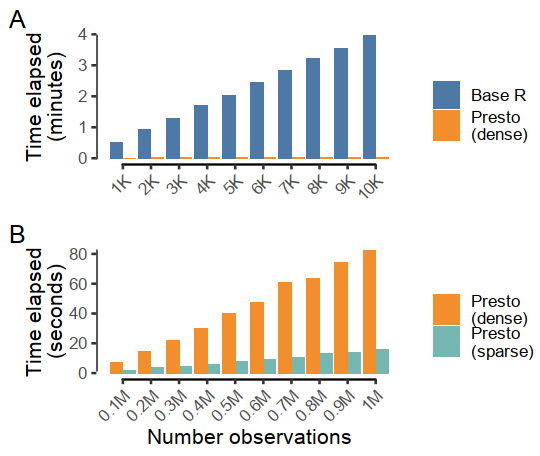

In [100]:
library(patchwork)
library(tidyverse)
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
library(ggthemes)
fig.size(3.8, 4.5)

time_res_N %>% 
    tidyr::gather(key, val, dense, base) %>% 
    subset(key %in% c('dense', 'base')) %>% 
    dplyr::mutate(key = case_when(
        key == 'dense' ~ 'Presto\n(dense)',
        key == 'base' ~ 'Base R',
        TRUE ~ key
    )) %>% 
    ggplot(aes(N, val / 60, fill = key)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        theme_tufte(base_size = 12)  + geom_rangeframe() + 
        scale_fill_manual(values = colors) + 
#         scale_fill_tableau() + 
        labs(
#             x = 'Number observations', 
             y = 'Time elapsed\n(minutes)', fill = ''
#              title = 'Presto and wilcox.test on moderately sized dataset'
            ) + 
#         scale_x_continuous(breaks = seq(1e3, 1e4, 1000)) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.title.x = element_blank()) + 
        scale_x_continuous(labels = paste0(seq(1, 10), 'K'), breaks = seq(1e3, 1e4, 1000)) + 

time_res_big_N %>% 
    tidyr::gather(key, val, dense, sparse) %>% 
    subset(key %in% c('dense', 'sparse')) %>% 
    dplyr::mutate(key = case_when(
        key == 'dense' ~ 'Presto\n(dense)',
        key == 'sparse' ~ 'Presto\n(sparse)',
        TRUE ~ key
    )) %>% 
    ggplot(aes(N, val, fill = key)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        theme_tufte(base_size = 12)  + geom_rangeframe() + 
        scale_fill_manual(values = colors) + 
        labs(x = 'Number observations', 
             y = 'Time elapsed\n(seconds)', fill = '') + 
#              title = 'Presto scales to big data') + 
#         scale_x_continuous(labels = seq(1, 10), breaks = seq(1e3, 1e4, 1000)) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
        scale_x_continuous(labels = paste0(seq(.1, 1, .1), 'M'), breaks = seq(1e5, 1e6, 1e5)) + 


plot_layout(ncol = 1) + 
plot_annotation(tag_levels = 'A')

In [102]:
devtools::check()
# getwd()

Updating presto documentation


Writing NAMESPACE


Loading presto


Writing NAMESPACE
Writing wilcoxauc.Rd
── Building ────────────────────────────────────────────────────────── presto ──
Setting env vars:
● CFLAGS    : -Wall -pedantic -fdiagnostics-color=always
● CXXFLAGS  : -Wall -pedantic -fdiagnostics-color=always
● CXX11FLAGS: -Wall -pedantic -fdiagnostics-color=always
────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/data/srlab/ik936/presto_manuscript/presto/DESCRIPTION’ (447ms)
─  preparing ‘presto’: (401ms)
✔  checking DESCRIPTION meta-information
─  cleaning src
─  installing the package to build vignettes
✔  creating vignettes (25.6s)
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘presto_0.99.0.tar.gz’
   
── Checking ────────────────────────────────────────────────────────── presto ──
Setting env vars:
● _R_CHECK_CRAN_INCOMING_U

ERROR: Error: R CMD check found ERRORs


# S4 objects

    For each one, find whether the exprs and metadata is stored
    
    Use accessor functions, not @ slots
    
    Is there a default place things get put? 

## Seurat V3

In [5]:
library(Seurat)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 80
Number of edges: 3124

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2397
Number of communities: 2
Elapsed time: 0 seconds


In [192]:
wilcoxauc.Seurat <- function(object, group_by=NULL, assay='data', seurat_assay='RNA') {
    X <- Seurat::GetAssayData(object, assay=seurat_assay, slot=assay)
    if (is.null(group_by)) {
        y <- Seurat::Idents(object)
    } else {
        y <- Seurat::FetchData(object, group_by) %>% unlist %>% as.character()        
    }
#     return(y)
    wilcoxauc(X, y)
}


In [195]:
pbmc_small <- Seurat::FindClusters(pbmc_small)
res_norm_counts <- wilcoxauc(pbmc_small, assay = 'data')
res_raw_counts <- wilcoxauc(pbmc_small, assay = 'counts')
res_scaled_counts <- wilcoxauc(pbmc_small, assay = 'scale.data')

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 80
Number of edges: 3124

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.2397
Number of communities: 2
Elapsed time: 0 seconds


In [197]:
# wilcoxauc(cell_lines_small_seurat_v3, 'cell_type')

In [198]:
# data(cell_lines_small_seurat_v3)
# wilcoxauc(cell_lines_small_seurat_v3, 'cell_type', 'logcounts') %>% head

## Monocle

data class: CellDataSet

In [212]:
library(monocle)

In [217]:
pbmc_small <- Seurat::pbmc_small
pd <- new("AnnotatedDataFrame", data = pbmc_small@meta.data)
# fd <- new("AnnotatedDataFrame", data = )
cds <- newCellDataSet(as.matrix(pbmc_small@assays$RNA@counts),
    phenoData = pd)#, featureData = fd)

cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

disp_table <- dispersionTable(cds)
ordering_genes <- subset(disp_table, mean_expression >= 0.1)
cds <- setOrderingFilter(cds, ordering_genes)
# cds <- reduceDimension(cds, reduction_method = 'tSNE')

cds <- clusterCells(cds)

Warning message in newCellDataSet(as.matrix(pbmc_small@assays$RNA@counts), phenoData = pd):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(as.matrix(pbmc_small@assays$RNA@counts), phenoData = pd):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Warning message in newCellDataSet(as.matrix(pbmc_small@assays$RNA@counts), phenoData = pd):
“Warning: featureData must contain a column verbatim named 'gene_short_name' for certain functions”Removing 10 outliers
ReduceDimension is not applied to this dataset. We are using the normalized reduced space obtained from preprocessCDS to cluster cells...


ERROR: Error in clusterCells(cds): reduced dimension space doesn't match the dimension of the CellDataSet object


## SingleCellExperiment

In [146]:
wilcoxauc.SingleCellExperiment <- function(object, group_by=NULL, assay=NULL) {
    if (is.null(group_by)) {
        stop('Must specify group_by with SingleCellExperiment')
    } else if (!group_by %in% names(colData(object))) {
        stop('group_by value is not defined in colData.')
    }
    y <- colData(object)[[group_by]]
    
    if (is.null(assay)) {
        standard_assays <- c('normcounts', 'logcounts', 'cpm', 'tpm', 'weights', 'counts')
        standard_assays <- factor(standard_assays, standard_assays)
        available_assays <- names(assays(object))    
        available_assays <- intersect(standard_assays, available_assays)
        if (length(available_assays) == 0) {
            stop('No assays in SingleCellExperiment object')
        } else {
            assay <- available_assays[1]
        }    
    } 
    
    X <- eval(call(assay, object))

    wilcoxauc(X, y)
}

In [147]:
data(cell_lines_small_sce)
wilcoxauc(cell_lines_small_sce, 'cell_type', 'logcounts') %>% head

gene,group,auc,avgExpr,logFC,padj,pct_in,pct_out,pval
G1,jurkat,0.5043351,5.957396,0.04064296,0.9989377,1,1,0.8972436
G1,t293,0.4983771,5.916753,-0.04064296,0.9989377,1,1,0.8972436
G10,jurkat,0.4613846,5.947356,0.02461972,0.9989377,1,1,0.4721737
G10,t293,0.4985550,5.922736,-0.02461972,0.9989377,1,1,0.4721737
G11,jurkat,0.4956649,5.962155,0.06974818,0.9989377,1,1,0.9046222
G11,t293,0.5016229,5.892407,-0.06974818,0.9989377,1,1,0.9046222


In [224]:
usethis::use_data(cell_lines_small_seurat_v3, overwrite = TRUE)
usethis::use_data(cell_lines_small_sce, overwrite = TRUE)

✔ Saving 'cell_lines_small_seurat_v3' to 'data/cell_lines_small_seurat_v3.rda'
✔ Saving 'cell_lines_small_sce' to 'data/cell_lines_small_sce.rda'


In [235]:
library(Matrix)

In [376]:
data(y)
data(exprs)
res_matrix <- wilcoxauc(as(exprs, 'matrix'), y)
res_dge <- wilcoxauc(as(exprs, 'dgeMatrix'), y)
res_dgt <- wilcoxauc(as(exprs, 'dgTMatrix'), y)
res_tsparse <- wilcoxauc(as(exprs, 'TsparseMatrix'), y)
res_dgc <- wilcoxauc(as(exprs, 'dgCMatrix'), y)
res_dgc <- wilcoxauc(as(exprs, 'DataFrame'), y)
res_df <- wilcoxauc(as.data.frame(exprs), y)




In [259]:
devtools::document()
devtools::load_all()

Updating presto documentation


Writing NAMESPACE


Loading presto


Writing NAMESPACE


Loading presto


In [385]:
    obj <- cell_lines_small_seurat_v3
    library(Seurat)

    res <- wilcoxauc(obj, 'cell_type')
#     res <- wilcoxauc(as.data.frame(exprs), y)


In [386]:
dim(res)

[1] 40 10

In [392]:
devtools::document()
devtools::load_all()

Updating presto documentation


Writing NAMESPACE


Loading presto


Writing NAMESPACE


Loading presto


In [395]:
devtools::test()

Loading presto
Testing presto


✔ | OK F W S | Context
✔ |  2       | Test correctness of Wilcox results [0.1 s]
✔ | 18       | Test main Presto runs on variety of input types [0.2 s]

══ Results ═════════════════════════════════════════════════════════════════════
Duration: 0.4 s

OK:       20
Failed:   0
Warnings: 0
Skipped:  0
